# Project 2

The purpose of this project is to build a model, that will be able to distinguish between different seal calls. 

Grey Seals are known for their wide repertoire of communications which range from clapping [[1]](https://www.smithsonianmag.com/smart-news/first-scientists-film-grey-seals-clapping-show-their-strength-180974133/) to vocalisations so complex that they have been shown to imitate the sounds of vowels and other building blocks of human speech [[2]](https://www.pbs.org/wgbh/nova/article/seals-mimic-speech/).

This project will look at specific vocalisations called Rupes and Moans.

There are 3 types of Rupes A, B and C and are distinguished from each other based on frequency, duration and modulation.

The dataset used in this project comes from a  study into the vocalisations of grey seals off of Malin head. [[3]](https://www.mdpi.com/2077-1312/12/1/118)

In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import glob
import os
from scipy.signal import spectrogram as compute_spectrogram  # was having an issue with name conflicts


In [2]:
# Folder containing the text files
folder_path = "data/Samples Grey Seal/Rupes A and B/"

# Initialize an empty list to store DataFrames
dataframes = []

# Get all .txt files in the folder
txt_files = glob.glob(os.path.join(folder_path, "*.txt"))

# Iterate through each text file
for txt_file in txt_files:
    # Get the base name of the corresponding .wav file
    base_name = os.path.splitext(os.path.basename(txt_file))[0].replace(".Table.1.selections", "")
    wav_file = f"{base_name}.wav"  # Name of the associated .wav file

    # Load the text file into a DataFrame
    df = pd.read_csv(txt_file, sep='\t', header='infer')

    # Add a column for the corresponding .wav file
    df['Audio File'] = wav_file

    # Append the DataFrame to the list
    dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the combined DataFrame
combined_df.head()

# Save the combined DataFrame to a CSV file for reference
combined_df.to_csv(os.path.join("data/combined_calls.csv"), index=False)

In [3]:
#look at full dataframe for every call
combined_df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,Audio File
0,1,Spectrogram 1,1,109.680390,109.926965,79.787,279.255,0.2466,199.468,-99.97,Rupe A,5713.210823180002.wav
1,2,Spectrogram 1,1,292.648496,292.765402,79.787,282.675,0.1169,202.888,-96.00,Rupe A,5713.210823180002.wav
2,3,Spectrogram 1,1,294.298675,294.379611,66.489,345.745,0.0809,279.256,-92.12,Rupe A,5713.210823180002.wav
3,4,Spectrogram 1,1,295.620051,295.720229,66.489,398.936,0.1002,332.447,-93.45,Rupe A,5713.210823180002.wav
4,5,Spectrogram 1,1,296.304983,296.534078,53.191,385.638,0.2291,332.447,-92.80,Rupe A,5713.210823180002.wav
...,...,...,...,...,...,...,...,...,...,...,...,...
502,43,Spectrogram 1,1,1045.177439,1045.300727,77.279,289.798,0.1233,212.519,-93.15,Rupe A,5713.210814160002.wav
503,44,Spectrogram 1,1,1151.581932,1151.837640,115.919,482.996,0.2557,367.077,-99.11,Rupe A,5713.210814160002.wav
504,45,Spectrogram 1,1,1179.857192,1180.026141,115.919,463.677,0.1689,347.758,-95.79,Rupe A,5713.210814160002.wav
505,46,Spectrogram 1,1,298.330294,298.447201,98.765,283.951,0.1169,185.186,-92.34,G rupe,5713.210814160002.wav


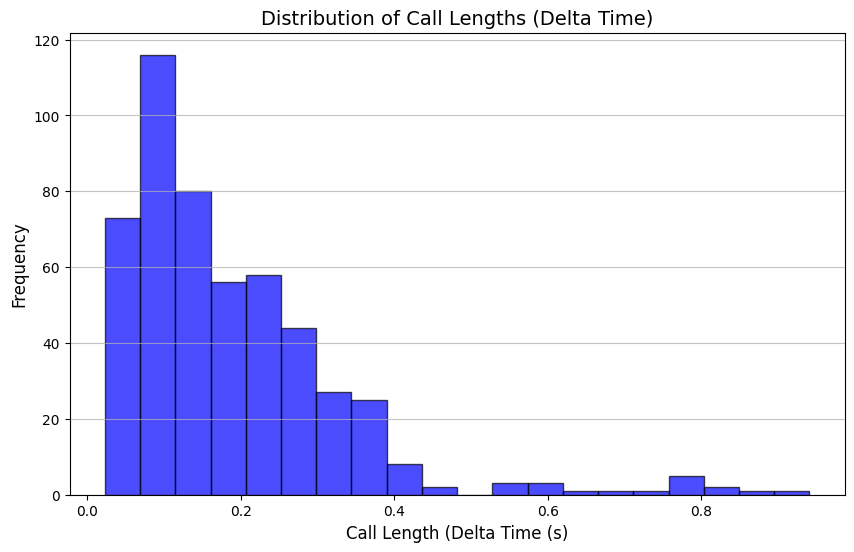

In [4]:
# PLot the distribution of call durations

# Plot the distribution of Delta Time (s)
plt.figure(figsize=(10, 6))
plt.hist(combined_df['Delta Time (s)'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Call Lengths (Delta Time)", fontsize=14)
plt.xlabel("Call Length (Delta Time (s)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

We can see above all the calls are very short, all under 1 second. For future analysis with a neural net we will want all samples to be of a similar size. As the calls will be centred in the middle of spectrogams, they will created 3 seocnds long to have a bit of buffer on either side.

## Non calls
It would also be interesting to compare these to non-calls. To do this we need to identify areas where no call is recorded. They will also be the same length of 3 seconds. Some of the audio files have beeps to signify the beginning of the audio. This is not something we want recording in our non-calls.  To avoid this we can start 5 seconds in. 

In [5]:
# Function to generate and save spectrograms
def generate_non_call_spectrogram(segment, sample_rate, time_start, annotation, output_path, fmin=20, fmax=1000, db_min=-30, db_max=0):
    # Compute the spectrogram
    frequencies, times, spectrogram = signal.spectrogram(
        segment, sample_rate, nperseg=1024, nfft=2048, noverlap=512, window='hann'
    )

    # Adjust times to reflect the original audio time range
    times = times + time_start

    # Trim tiny values to avoid issues with log scale
    spectrogram[spectrogram < 0.001] = 0.001  # Avoid log(0) errors

    # Convert to decibels
    spectrogram_db = 10 * np.log10(spectrogram)

    # Define the frequency range of interest
    freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

    # Keep only the frequencies of interest
    frequencies = frequencies[freq_slice]
    spectrogram_db = spectrogram_db[freq_slice, :][0]

    # Plot the spectrogram
    fig, ax = plt.subplots(figsize=(10, 6))
    pc = ax.pcolormesh(
        times,
        frequencies,
        spectrogram_db,
        shading='gouraud',
        vmin=db_min,  # Fixed lower limit
        vmax=db_max,  # Fixed upper limit
        cmap='viridis'
    )
    cbar = plt.colorbar(pc, ax=ax, label="Power (dB)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Spectrogram - Annotation: {annotation}")

        # Function to update the colormap dynamically
    def update_colormap(event):
        nonlocal pc, cbar
        # Get current view limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Find indices corresponding to the current view limits
        x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
        y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

        # Handle cases where no data is visible
        if len(x_indices) == 0 or len(y_indices) == 0:
            return

        # Compute fixed color limits
        vmin = -30
        vmax = 0

        # Update the color limits of the pcolormesh
        pc.set_clim(vmin=vmin, vmax=vmax)

        # Update the colorbar to reflect the new color limits
        cbar.update_normal(pc)

        # Redraw the figure
        plt.draw()

    # Connect the update_colormap function to zoom/pan events
    fig.canvas.mpl_connect('button_release_event', update_colormap)

    # Save the figure
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close(fig)

In [6]:
# create non calls
first_audio_file  = "data/Samples Grey Seal/Rupes A and B/5713.210806110002.wav"
first_text_file = "data/Samples Grey Seal/Rupes A and B/5713.210806110002.Table.1.selections.txt"
output_folder = 'data/processed/Spectrograms'

# Load annotations
non_call_df = pd.read_csv(first_text_file, sep='\t')

# Load audio
try:
    sr, audio = wavfile.read(first_audio_file)
except Exception as e:
    raise ValueError(f"Failed to read audio file: {e}")

# Convert stereo to mono if necessary
if len(audio.shape) > 1:
    audio = audio[:, 0]

# Calculate the total duration of the audio file
audio_duration = len(audio) / sr
    
# Identify non-call segments, ensuring the first sample starts after 5 seconds
call_intervals = non_call_df[['Begin Time (s)', 'End Time (s)']].values

# Define the start point and duration
start_time = 5  # Start checking for non-calls after 5 seconds
audio_duration = len(audio) / sr  # Total duration of the audio
chunk_duration = 3  # Each non-call segment is 3 seconds

# Generate all possible 3-second chunks
non_call_segments = []
current_time = start_time

while current_time + chunk_duration <= audio_duration:
    segment_start = current_time
    segment_end = segment_start + chunk_duration

    # Exclude segments where a call starts or ends inside
    overlap = (
        ((non_call_df['Begin Time (s)'] >= segment_start) & (non_call_df['Begin Time (s)'] < segment_end)).any() or
        ((non_call_df['End Time (s)'] > segment_start) & (non_call_df['End Time (s)'] <= segment_end)).any()
    )

    # If no overlap, add to non-call segments
    if not overlap:
        non_call_segments.append((segment_start, segment_end))

    # Move to the next chunk
    current_time += chunk_duration

# Debugging output to verify
print(f"Identified non-call segments: {non_call_segments}")

Identified non-call segments: [(5, 8), (8, 11), (14, 17), (17, 20), (20, 23), (23, 26), (29, 32), (32, 35), (35, 38), (38, 41), (41, 44), (44, 47), (47, 50), (50, 53), (56, 59), (59, 62), (62, 65), (68, 71), (71, 74), (74, 77), (77, 80), (83, 86), (89, 92), (92, 95), (101, 104), (110, 113), (113, 116), (131, 134), (134, 137), (137, 140), (146, 149), (149, 152), (152, 155), (155, 158), (158, 161), (161, 164), (164, 167), (167, 170), (170, 173), (173, 176), (176, 179), (179, 182), (182, 185), (185, 188), (188, 191), (191, 194), (194, 197), (197, 200), (200, 203), (203, 206), (206, 209), (209, 212), (212, 215), (215, 218), (218, 221), (221, 224), (224, 227), (227, 230), (230, 233), (233, 236), (236, 239), (239, 242), (245, 248), (248, 251), (254, 257), (257, 260), (266, 269), (269, 272), (272, 275), (275, 278), (281, 284), (284, 287), (287, 290), (290, 293), (293, 296), (296, 299), (299, 302), (302, 305), (305, 308), (311, 314), (314, 317), (317, 320), (320, 323), (323, 326), (326, 329), 

In [7]:
# Generate spectrograms for non-call segments, capped at 100
spectrogram_data = []
spectrogram_count = 0
MAX_SPECTROGRAMS = 100
output_folder = "data/processed/Spectrograms"

for start, end in non_call_segments:
    if spectrogram_count >= MAX_SPECTROGRAMS:
        break  # Stop processing after reaching the maximum number of spectrograms

    # Extract the audio segment
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    clip_audio = audio[start_sample:end_sample]

    # Generate and save the spectrogram
    output_path = os.path.join(output_folder, f"non-call-{spectrogram_count + 1}.png")
    annotation = f"Non-Call {spectrogram_count + 1}"

    try:
        generate_non_call_spectrogram(
            clip_audio, sr, start, annotation, output_path, fmin=20, fmax=1000, db_min=-30, db_max=0
        )
    except Exception as e:
        print(f"Failed to generate spectrogram for segment {start}-{end}: {e}")
        continue

    # Append metadata for the spectrogram
    spectrogram_data.append({
        'Selection': len(df) + len(spectrogram_data) + 1,
        'View': 1,
        'Channel': 1,
        'Begin Time (s)': start,
        'End Time (s)': end,
        'Low Freq (Hz)': 20,
        'High Freq (Hz)': 1000,
        'Delta Time (s)': 3,
        'Delta Freq (Hz)': 1000 - 20,
        'Avg Power Density (dB FS/Hz)': np.mean(clip_audio) if clip_audio.size > 0 else None,
        'Annotation': "Non call",
        'Audio File': "5713.210806110002.wav"
    })

    spectrogram_count += 1  # Increment the count for each generated spectrogram

# Combine data and save
non_call_df = pd.DataFrame(spectrogram_data)

print(f"Original DataFrame shape: {combined_df.shape}")
print(f"Non-call DataFrame shape: {non_call_df.shape}")

# Concatenate DataFrames
combined_df = pd.concat([combined_df, non_call_df], ignore_index=True)

combined_df.to_csv('data/combined_calls.csv', index=False)

print("Non-call spectrograms generated and dataframe updated.")

Original DataFrame shape: (507, 12)
Non-call DataFrame shape: (100, 12)
Non-call spectrograms generated and dataframe updated.


In [8]:
# View dataframe
#non_call_df
combined_df.shape

(607, 12)

In [9]:
# Check what calls are included and how many of each

unique_calls = combined_df['Annotation'].value_counts(sort=False)
unique_calls

Annotation
Rupe A           342
Rupe C             8
Rupe B           121
Growl B            2
Type 4 A          12
Trrot              4
Unidentified       1
??                 2
?                  2
G rupe             5
Guttural rupe      7
unidentified       1
Non call         100
Name: count, dtype: int64

Some of the calls were un-identified or were identified as Trrot or Type 4 A. I am unsure what type of call this is. However they are in low number and will be excluded from our project going forward. 

The only calls that have sufficient samples are the Rupe A, Rupe B and Non-calls.

In [10]:
#List of Annotation types that we want to keep

annotations_to_include = ['Rupe A', 'Rupe B', 'Non call']
filtered_df = combined_df[combined_df['Annotation'].isin(annotations_to_include)]

filtered_df['Annotation'].value_counts(sort=False)


Annotation
Rupe A      342
Rupe B      121
Non call    100
Name: count, dtype: int64

In [11]:
filtered_df.tail

<bound method NDFrame.tail of      Selection           View  Channel  Begin Time (s)  End Time (s)  \
0            1  Spectrogram 1        1      109.680390    109.926965   
1            2  Spectrogram 1        1      292.648496    292.765402   
2            3  Spectrogram 1        1      294.298675    294.379611   
3            4  Spectrogram 1        1      295.620051    295.720229   
4            5  Spectrogram 1        1      296.304983    296.534078   
..         ...            ...      ...             ...           ...   
602        143              1        1      359.000000    362.000000   
603        144              1        1      362.000000    365.000000   
604        145              1        1      365.000000    368.000000   
605        146              1        1      368.000000    371.000000   
606        147              1        1      371.000000    374.000000   

     Low Freq (Hz)  High Freq (Hz)  Delta Time (s)  Delta Freq (Hz)  \
0           79.787         279.255

In [12]:
row1 = filtered_df.iloc[500]
row2 = filtered_df.iloc[18]
row3 = filtered_df.iloc[19]

row1['Annotation'], row2['Annotation'], row3['Annotation']

('Non call', 'Rupe A', 'Rupe B')

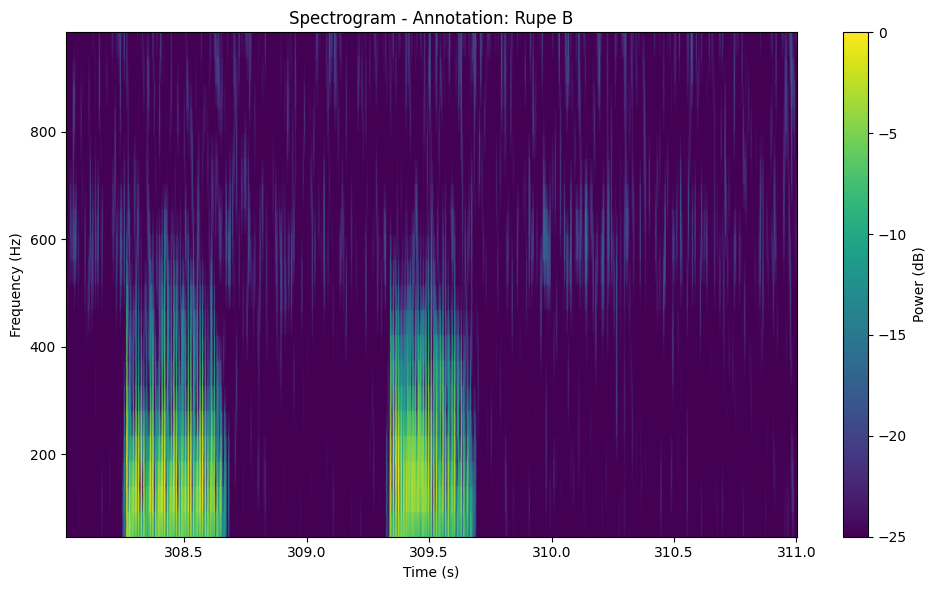

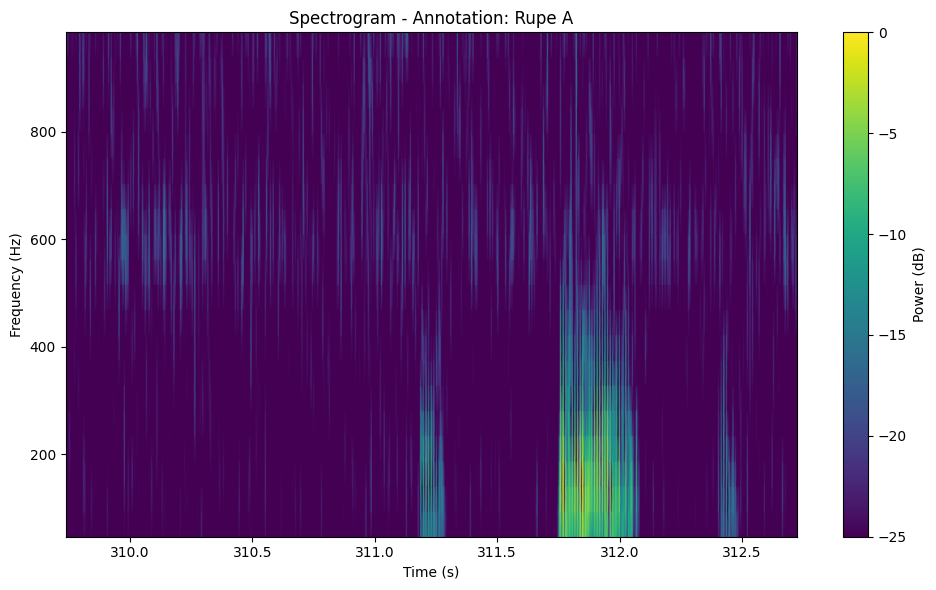

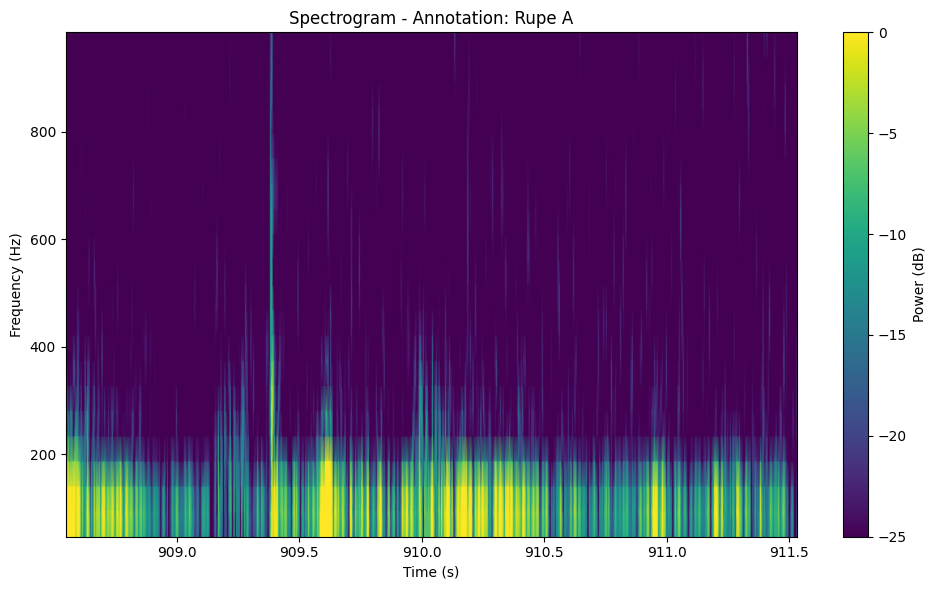

In [13]:
def visualize_spectrogram_with_dynamic_colormap(segment, sample_rate, time_start, annotation, fmin=20, fmax=1000, db_min=-25, db_max=0):
    
    # Compute the spectrogram
    frequencies, times, spectrogram = signal.spectrogram(
        segment, sample_rate, nperseg=1024, nfft=2048, noverlap=512, window='hann'
    )

    # Adjust times to reflect the original audio time range
    times = times + time_start

    # Trim tiny values to avoid issues with log scale
    spectrogram[spectrogram < 0.001] = 0.001  # Avoid log(0) errors

    # Convert to decibels
    spectrogram_db = 10 * np.log10(spectrogram)

    # Define the frequency range of interest
    freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

    # Keep only the frequencies of interest
    frequencies = frequencies[freq_slice]
    spectrogram_db = spectrogram_db[freq_slice, :][0]

    # Plot the spectrogram
    fig, ax = plt.subplots(figsize=(10, 6))
    pc = ax.pcolormesh(times, frequencies, spectrogram_db, shading='gouraud', vmin=-25, vmax=db_max, cmap='viridis')
    cbar = plt.colorbar(pc, ax=ax, label="Power (dB)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Spectrogram - Annotation: {annotation}")

    # Function to update the colormap dynamically
    def update_colormap(event):
        nonlocal pc, cbar
        # Get current view limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Find indices corresponding to the current view limits
        x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
        y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

        # Handle cases where no data is visible
        if len(x_indices) == 0 or len(y_indices) == 0:
            return

        # Extract the visible data
        data_visible = spectrogram_db[np.ix_(y_indices, x_indices)]

        # Compute new color limits
        vmin = -25
        vmax = 0

        # Update the color limits of the pcolormesh
        pc.set_clim(vmin=-25, vmax=db_max)

        # Update the colorbar to reflect the new color limits
        cbar.update_normal(pc)

        # Redraw the figure
        plt.draw()

    # Connect the update_colormap function to zoom/pan events
    fig.canvas.mpl_connect('button_release_event', update_colormap)

    plt.tight_layout()
    plt.show()

rupe_path = "data/Samples Grey Seal/Rupes A and B"

# Look at one of each class of call to visualize
indices_to_visualize = [18, 19, 500]  
for idx, row in filtered_df.iterrows():
    if idx not in indices_to_visualize:
        continue
        

    # Get the associated audio file
    audio_path = os.path.join(rupe_path, row['Audio File'])

    # Load the audio file
    if not os.path.exists(audio_path):
        print(f"Audio file {audio_path} not found. Skipping...")
        continue

    sample_rate, samples = wavfile.read(audio_path)

    # Calculate the midpoint of the call
    call_midpoint = (row['Begin Time (s)'] + row['End Time (s)']) / 2

    # Define the 3-second time window around the call
    time_start = call_midpoint - 1.5
    time_end = call_midpoint + 1.5

    # Convert time to sample indices
    start_sample = int(time_start * sample_rate)
    end_sample = int(time_end * sample_rate)

    # Handle edge cases where the segment exceeds the audio boundaries
    if start_sample < 0:
        start_sample = 0
    if end_sample > len(samples):
        end_sample = len(samples)

    # Extract the audio segment
    segment = samples[start_sample:end_sample]  

    # Visualize the spectrogram for the selected call
    visualize_spectrogram_with_dynamic_colormap(segment, sample_rate, time_start, row['Annotation'])

In [14]:
# Iterate through each row in the combined DataFrame
for index, row in filtered_df.iterrows():
    # Get the associated audio file
    audio_path = os.path.join(folder_path, row['Audio File'])

    # Load the audio file
    if not os.path.exists(audio_path):
        print(f"Audio file {audio_path} not found. Skipping...")
        continue

    sample_rate, samples = wavfile.read(audio_path)

    # Calculate the midpoint of the call
    call_midpoint = (row['Begin Time (s)'] + row['End Time (s)']) / 2

    # Define the 3-second time window around the call
    time_start = call_midpoint - 1.5
    time_end = call_midpoint + 1.5

    # Convert time to sample indices
    start_sample = int(time_start * sample_rate)
    end_sample = int(time_end * sample_rate)

    # Handle edge cases where the segment exceeds the audio boundaries
    if start_sample < 0:
        start_sample = 0
    if end_sample > len(samples):
        end_sample = len(samples)

    # Extract the audio segment
    segment = samples[start_sample:end_sample]

    # Compute the spectrogram for the segment
    frequencies, times, spectrogram = signal.spectrogram(
        segment, sample_rate, nperseg=1024, nfft=2048, noverlap=512, window='hann'
    )

    # Adjust times to reflect the original audio time range
    times = times + time_start  # Shift the spectrogram time axis to match the original audio timestamps

    # Save the spectrogram data as a .npz file
    output_file = os.path.join(f"data/processed/NPZ_files/{row['Audio File']}_call_{index + 1}_{row['Annotation'].replace(' ', '_')}.npz")
    np.savez_compressed(
        output_file,
        spectrogram=spectrogram,
        frequencies=frequencies,
        times=times,
        annotation=row['Annotation'],
        time_start=time_start,
        time_end=time_end
    )

    #print(f"Processed call {index + 1} from {row['Audio File']} and saved as .npz.")

In [15]:
#look at a npz file. 

npz_data = np.load('data/processed/NPZ_files/5713.210806110002.wav_call_70_Rupe_B.npz')
npz_data.files
#npz_data.keys()
#npz_data['spectrogram'].shape

#for key in npz_data.keys():
#    print(f"\nArray name: {key}")
#    print(f"Array content:\n{npz_data[key]}")
#    print(f"Array shape: {npz_data[key].shape}")

['spectrogram', 'frequencies', 'times', 'annotation', 'time_start', 'time_end']

ValueError: 'Spectral-r' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

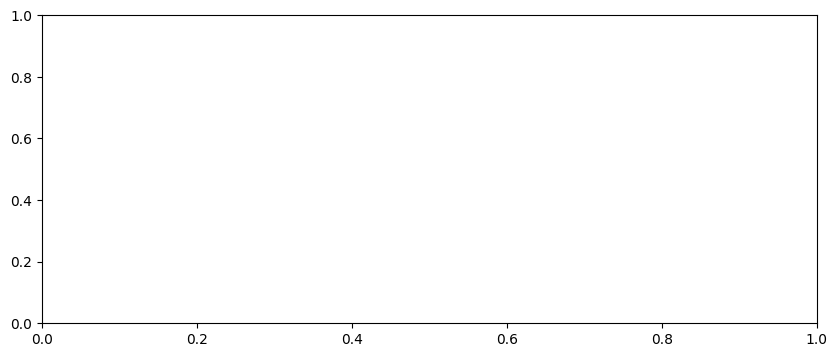

In [16]:
# DONT NEED THIS ANYMROE 
# 
# Assuming npz_data['spectrogram'] contains the spectrogram
spectrogram = npz_data['spectrogram']

# Normalize to decibels
spectrogram_dB = 10 * np.log10(spectrogram + 1e-10)  # Add small value to avoid log(0)


# Visualize the normalized spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_dB, aspect='auto', origin='lower', cmap='Spectral-r', vmin=-100, vmax=0)  # Adjust vmin/vmax if necessary
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')
plt.title('Spectrogram (Normalized in Decibels)')
plt.show()

print(f"Spectrogram min: {spectrogram_dB.min()}")
print(f"Spectrogram max: {spectrogram_dB.max()}")
print(f"Spectrogram mean: {spectrogram_dB.mean()}")

In [ ]:
folder_path = "data/Samples Grey Seal/Rupes A and B"

# Get all .wav files in the folder
audio_files = glob.glob(os.path.join(folder_path, "*.wav"))


file = "data/Samples Grey Seal/Rupes A and B/5713.210806110002"
audio_path = f'{file}.wav'
txt_path = f'{file}.Table.1.selections.txt'

# Load the audio file
sample_rate, samples = wavfile.read(audio_path)

# Step 2: Load the text file into a DataFrame
calls_df = pd.read_csv(txt_path, sep='\t', header='infer')
calls_df

In [3]:
# Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C": "purple",
    "Moan": "pink",
    "G rupe": "blue"
}

In [4]:
# Function to extract a centered 3-second audio segment
def extract_centered_segment(start_time, end_time, samples, sample_rate, segment_length=3.0):
    call_midpoint = (start_time + end_time) / 2  # Calculate the midpoint of the call

    # starting 1.5 secnods before the call midpoint
    segment_start_time = call_midpoint - segment_length / 2
    # ending 1.5 secnods after the call midpoint
    segment_end_time = call_midpoint + segment_length / 2

    # Convert time to sample indices
    start_sample = int(segment_start_time * sample_rate)
    end_sample = int(segment_end_time * sample_rate)

    # Handle edge cases: if the window goes outside the audio range
    if start_sample < 0:
        padding_start = abs(start_sample)
        start_sample = 0
    else:
        padding_start = 0

    if end_sample > len(samples):
        padding_end = end_sample - len(samples)
        end_sample = len(samples)
    else:
        padding_end = 0

    # Extract the segment and pad with zeros if necessary
    segment = samples[start_sample:end_sample]
    if padding_start > 0 or padding_end > 0:
        segment = np.pad(segment, (padding_start, padding_end), mode='constant')
    
    return segment

# Function to overlay annotations
def overlay_annotations(ax, row, annotation_colors):
    # Extract annotation details
    start_time = 1.5  # Call is always centered at 1.5 seconds in the 3-second segment
    end_time = 1.5 + (row['End Time (s)'] - row['Begin Time (s)'])
    low_freq = row['Low Freq (Hz)']
    high_freq = row['High Freq (Hz)']
    annotation = row['Annotation']

    # Skip if the annotation is not in the defined colors
    if annotation not in annotation_colors:
        return

    # Add a rectangle to the plot
    rect = Rectangle(
        (start_time, low_freq),  # Bottom-left corner
        end_time - start_time,  # Width (duration of the call)
        high_freq - low_freq,  # Height (frequency range of the call)
        edgecolor=annotation_colors[annotation],
        facecolor='none',
        linewidth=2,
        label=annotation
    )
    ax.add_patch(rect)

In [ ]:
for index, row in calls_df.iterrows():
    # Calculate the midpoint of the call
    call_midpoint = (row['Begin Time (s)'] + row['End Time (s)']) / 2

    # Define the 3-second time window around the call
    time_start = call_midpoint - 1.5
    time_end = call_midpoint + 1.5

    # Convert time to sample indices
    start_sample = int(time_start * sample_rate)
    end_sample = int(time_end * sample_rate)

    # Handle edge cases where the segment exceeds the audio boundaries
    if start_sample < 0:
        start_sample = 0
    if end_sample > len(samples):
        end_sample = len(samples)

    # Extract the audio segment
    segment = samples[start_sample:end_sample]

    # Compute the spectrogram for the segment
    frequencies, times, spectrogram = signal.spectrogram(
        segment, sample_rate, nperseg=1024, nfft=2048, noverlap=512, window='hann'
    )

    # Adjust times to reflect the original audio time range
    times = times + time_start  # Shift the spectrogram time axis to match the original audio timestamps

    # Trim the spectrogram frequencies to the desired range (20 Hz to 1000 Hz)
    freq_start, freq_end = 20, 700  # Frequency range in Hz
    freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]
    frequencies = frequencies[freq_indices]
    spectrogram = spectrogram[freq_indices, :]

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
    cbar = plt.colorbar(pc)
    cbar.set_label('Power [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f"Spectrogram for Call {index + 1} ({row['Annotation']})")

    annotation_cleaned = row['Annotation'].replace(" ", "_")

    # Save the spectrogram as an image
    plt.tight_layout()
    plt.savefig(f'data/processed/Spectrograms/spectrogram_call_{index + 1}_{annotation_cleaned}.png')
    plt.close()

print("Spectrograms generated for all calls.")